# Cropping a mesh while preserving detail up to the boundary

When cropping a mesh, the vertices of a triangle surface may end up on either side of the division, losing information on the mesh structure.

To get around this, we use VTK's functionality to extend the mesh to the boundary, creating new vertices and polygons to restore the lost information.

This is especially important when scaling up our application, so that we can divide HBIM meshes themselves and generate point clouds in segments that are contained entirely in-core.

# Example

In this example we generate a sphere with some fixed resolution in theta and phi, and then select the inner section of the mesh on the x axis.

We then extend the cropped sphere mesh up to the cropping boundary, and then re-triangularise the output.

We can then optionally create new po

In [1]:
import vtkmodules.vtkInteractionStyle
import vtkmodules.vtkRenderingOpenGL2
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkCommonCore import vtkUnsignedCharArray
from vtkmodules.vtkCommonDataModel import vtkPlane, vtkPolyData
from vtkmodules.vtkFiltersCore import (
    vtkClipPolyData,
    vtkTriangleFilter,
    vtkProbeFilter,
    vtkPolyDataNormals,
    vtkAppendPolyData,
    vtkFeatureEdges,
    vtkStripper
)
from vtkmodules.vtkFiltersSources import vtkSphereSource
from vtkmodules.vtkFiltersModeling import vtkContourLoopExtraction
# from vtkmodules.vtkFiltersGeneral import 
from vtkmodules.vtkRenderingCore import (
    vtkActor,
    vtkPolyDataMapper,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer
)
import numpy as np

colors = vtkNamedColors()

def create_colored_sphere():
    sphere = vtkSphereSource()
    sphere.SetThetaResolution(20)
    sphere.SetPhiResolution(20)
    sphere.Update()
    polyData = sphere.GetOutput()

    # Generate colors for each vertex based on their position
    colors = vtkUnsignedCharArray()
    colors.SetNumberOfComponents(3)
    colors.SetName("Colors")

    # Generate a smooth color gradient based on the x-coordinate of each point
    for i in range(polyData.GetNumberOfPoints()):
        point = polyData.GetPoint(i)
        r = int(255 * (point[0] + 0.5))
        g = int(255 * (0.5 - point[0]))
        b = 100
        colors.InsertNextTuple3(r, g, b)

    polyData.GetPointData().SetScalars(colors)
    return polyData


def clip_and_cap_mesh(original_mesh, crop_fraction=0.25, close_end_caps=True):
    # Get the bounds of the original mesh to set up the clipping
    bounds = original_mesh.GetBounds()

    # Calculate the cropping boundaries in the x direction
    x_min_crop = bounds[0] + ((1 - crop_fraction) / 2) * (bounds[1] - bounds[0])
    x_max_crop = bounds[0] + ((1 + crop_fraction) / 2) * (bounds[1] - bounds[0])

    print(f"Mesh bounds: {bounds}")
    print(f"Clipping region in x: [{x_min_crop}, {x_max_crop}]")

    # Define clipping planes for the cropped region in x direction
    plane_x_min = vtkPlane()
    plane_x_min.SetOrigin(x_min_crop, 0, 0)
    plane_x_min.SetNormal(1, 0, 0)

    plane_x_max = vtkPlane()
    plane_x_max.SetOrigin(x_max_crop, 0, 0)
    plane_x_max.SetNormal(-1, 0, 0)

    # Clip the mesh to the middle region in x direction using new clipper instances
    clipper1 = vtkClipPolyData()
    clipper1.SetInputData(original_mesh)
    clipper1.SetClipFunction(plane_x_min)
    clipper1.GenerateClippedOutputOn()
    clipper1.Update()
    clipped_x_min = clipper1.GetOutput()

    print(f"After clipping with plane_x_min: Points = {clipped_x_min.GetNumberOfPoints()}, Cells = {clipped_x_min.GetNumberOfCells()}")

    clipper2 = vtkClipPolyData()
    clipper2.SetInputData(clipped_x_min)
    clipper2.SetClipFunction(plane_x_max)
    clipper2.GenerateClippedOutputOn()
    clipper2.Update()
    clipped_x = clipper2.GetOutput()

    print(f"After clipping with plane_x_max: Points = {clipped_x.GetNumberOfPoints()}, Cells = {clipped_x.GetNumberOfCells()}")

    if clipped_x.GetNumberOfPoints() == 0:
        print("The clipped mesh is empty. Adjust the clipping planes or check the input mesh.")
        return None

    # Triangulate the clipped mesh to ensure all polygons are triangles
    tri_filter = vtkTriangleFilter()
    tri_filter.SetInputData(clipped_x)
    tri_filter.Update()
    triangulated_clipped_mesh = tri_filter.GetOutput()

    # Interpolate colors from the original mesh to the triangulated clipped mesh
    probe_filter = vtkProbeFilter()
    probe_filter.SetInputData(triangulated_clipped_mesh)
    probe_filter.SetSourceData(original_mesh)
    probe_filter.Update()

    interpolated_clipped_mesh = probe_filter.GetOutput()

    if close_end_caps:
        # Compute normals for the interpolated mesh
        normals_filter = vtkPolyDataNormals()
        normals_filter.SetInputData(interpolated_clipped_mesh)
        normals_filter.ComputePointNormalsOn()
        normals_filter.Update()
        interpolated_clipped_mesh = normals_filter.GetOutput()

        # Close the end caps
        edges = vtkFeatureEdges()
        edges.SetInputData(interpolated_clipped_mesh)
        edges.BoundaryEdgesOn()
        edges.FeatureEdgesOff()
        edges.NonManifoldEdgesOff()
        edges.ManifoldEdgesOff()
        edges.Update()

        stripper = vtkStripper()
        stripper.SetInputData(edges.GetOutput())
        stripper.Update()

        contour_loop_extraction = vtkContourLoopExtraction()
        contour_loop_extraction.SetInputData(stripper.GetOutput())
        contour_loop_extraction.Update()

        # Triangulate the contour loops to ensure end caps are triangles
        cap_triangulator = vtkTriangleFilter()
        cap_triangulator.SetInputData(contour_loop_extraction.GetOutput())
        cap_triangulator.Update()

        # Append the triangulated end caps to the original mesh
        append_filter = vtkAppendPolyData()
        append_filter.AddInputData(interpolated_clipped_mesh)
        append_filter.AddInputData(cap_triangulator.GetOutput())
        append_filter.Update()

        final_mesh = append_filter.GetOutput()
    else:
        final_mesh = interpolated_clipped_mesh

    return final_mesh


def visualize_mesh(mesh):
    # Set up mapper and actor for the clipped object
    clipMapper = vtkPolyDataMapper()
    clipMapper.SetInputData(mesh)

    clipActor = vtkActor()
    clipActor.SetMapper(clipMapper)
    clipActor.GetProperty().SetInterpolationToFlat()
    clipActor.GetProperty().EdgeVisibilityOn()

    # Create renderer, render window, and interactor
    renderer = vtkRenderer()
    renderWindow = vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    interactor = vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)

    # Set background color and size
    renderer.SetBackground(colors.GetColor3d('SlateGray'))
    renderWindow.SetSize(640, 480)

    # Add actor to the renderer
    renderer.AddActor(clipActor)

    # Generate an interesting view
    renderer.ResetCamera()
    renderer.GetActiveCamera().Azimuth(30)
    renderer.GetActiveCamera().Elevation(30)
    renderer.GetActiveCamera().Dolly(1.2)
    renderer.ResetCameraClippingRange()

    # Render and start interaction
    renderWindow.Render()
    renderWindow.SetWindowName('Colored Sphere - Clipped, Interpolated, and Triangulated')
    interactor.Start()


# Create the sphere with a color gradient
original_mesh = create_colored_sphere()

# Visualize the final mesh interactively
# if clipped_mesh:
#     visualize_mesh(clipped_mesh)


In [2]:
import vtk
from vtkmodules.vtkRenderingCore import (
    vtkRenderWindow, vtkRenderWindowInteractor, vtkRenderer, vtkPolyDataMapper, vtkActor
)
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkInteractionStyle import vtkInteractorStyleTrackballCamera
from vtkmodules.vtkRenderingOpenGL2 import vtkOpenGLRenderWindow
from vtkmodules.vtkRenderingCore import vtkWindowToImageFilter
from vtkmodules.vtkIOImage import vtkPNGWriter
from vtkmodules.util.numpy_support import vtk_to_numpy  # Correct import for vtk_to_numpy

import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

def plot_vtk_mesh_inline(mesh, window_name="VTK Mesh Viewer", azimuth=45, elevation=45, roll=0, zoom=1.2):
    """
    Visualizes a VTK mesh (vtkPolyData) inline in Jupyter Notebook using matplotlib.

    Args:
        mesh (vtk.vtkPolyData): The VTK mesh to visualize.
        window_name (str): The name of the render window.
        azimuth (float): Azimuth angle for camera positioning.
        elevation (float): Elevation angle for camera positioning.
        roll (float): Roll angle for camera positioning.
        zoom (float): Zoom factor for the camera.
    """
    # Set up renderer and render window
    renderer = vtkRenderer()
    render_window = vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)
    render_window.SetWindowName(window_name)

    # Set up mesh actor
    mapper = vtkPolyDataMapper()
    mapper.SetInputData(mesh)

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetInterpolationToFlat()
    actor.GetProperty().EdgeVisibilityOn()

    # Add actor to renderer
    renderer.AddActor(actor)

    # Set background color
    colors = vtkNamedColors()
    renderer.SetBackground(colors.GetColor3d('SlateGray'))

    # Adjust camera position
    renderer.ResetCamera()
    renderer.GetActiveCamera().Azimuth(azimuth)
    renderer.GetActiveCamera().Elevation(elevation)
    renderer.GetActiveCamera().Roll(roll)
    renderer.GetActiveCamera().Zoom(zoom)
    renderer.ResetCameraClippingRange()

    # Render to an off-screen buffer
    render_window.SetOffScreenRendering(1)
    render_window.Render()

    # Capture the image from the render window
    window_to_image_filter = vtkWindowToImageFilter()
    window_to_image_filter.SetInput(render_window)
    window_to_image_filter.Update()

    # Convert VTK image to a NumPy array
    vtk_image = window_to_image_filter.GetOutput()
    width, height, _ = vtk_image.GetDimensions()
    vtk_array = vtk_image.GetPointData().GetScalars()
    components = vtk_array.GetNumberOfComponents()
    numpy_image = vtk_to_numpy(vtk_array).reshape(height, width, components)
    numpy_image = np.flipud(numpy_image)  # Flip vertically to match VTK's bottom-left origin

    # Plot using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.title(window_name)
    plt.show()

Mesh bounds: (-0.4982922375202179, 0.4982922375202179, -0.4982922375202179, 0.4982922375202179, -0.5, 0.5)
Clipping region in x: [-0.22423150688409804, 0.224231506884098]
After clipping with plane_x_min: Points = 436, Cells = 632
After clipping with plane_x_max: Points = 428, Cells = 544


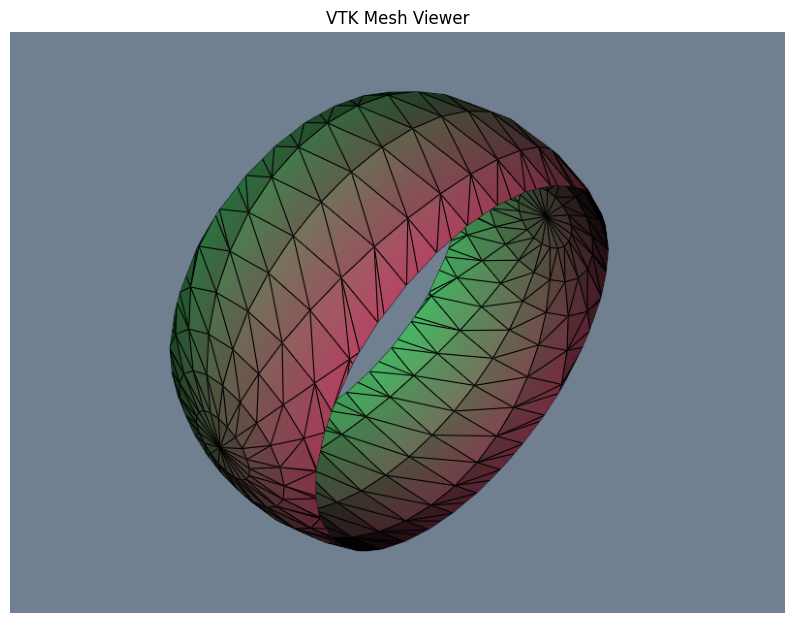

In [3]:
clipped_mesh = clip_and_cap_mesh(original_mesh, crop_fraction=0.45, close_end_caps=False)
plot_vtk_mesh_inline(clipped_mesh)

Mesh bounds: (-0.4982922375202179, 0.4982922375202179, -0.4982922375202179, 0.4982922375202179, -0.5, 0.5)
Clipping region in x: [-0.22423150688409804, 0.224231506884098]
After clipping with plane_x_min: Points = 436, Cells = 632
After clipping with plane_x_max: Points = 428, Cells = 544


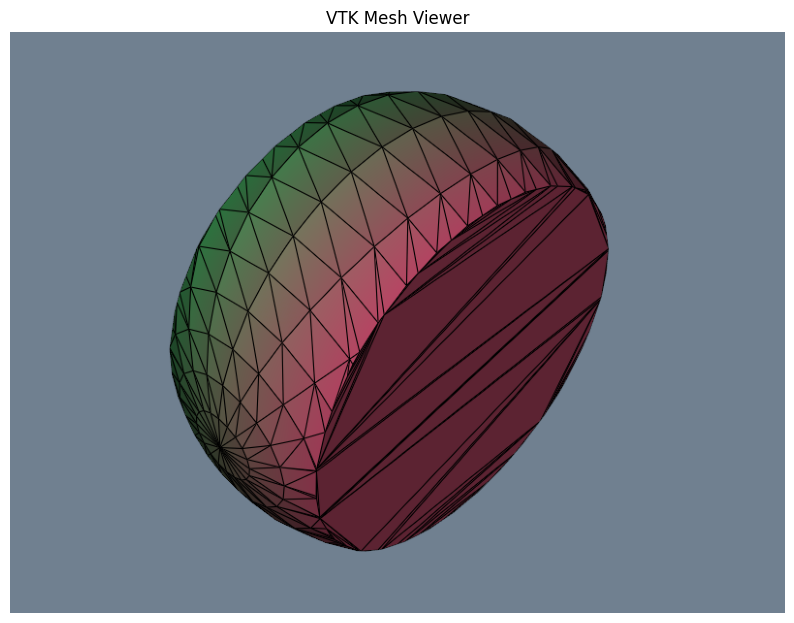

In [4]:
capped_mesh = clip_and_cap_mesh(original_mesh, crop_fraction=0.45, close_end_caps=True)
plot_vtk_mesh_inline(capped_mesh)